In [ ]:
# unsupervised clustering using dinov2 ViT

# Imports/Calling Data

In [5]:
!pip install torch torchvision timm --quiet

Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /home/jovyan/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /home/jovyan/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 250MB/s]
100%|██████████| 10769/10769 [13:39<00:00, 13.14it/s]


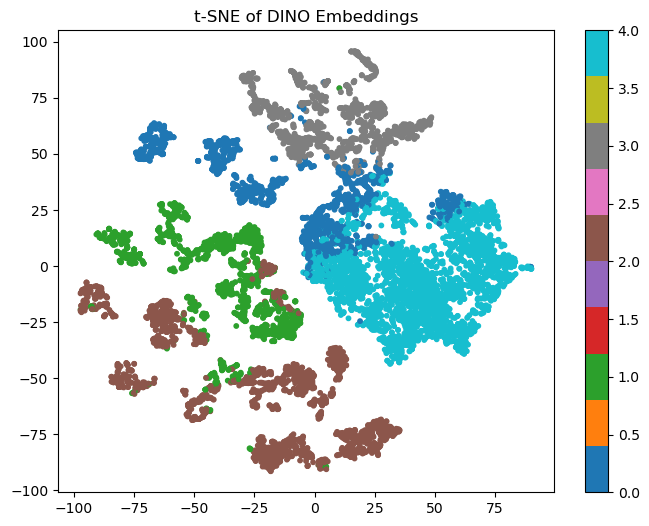

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import timm
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# images path & general settings
# --- Change this image path to whatever image collection you want to cluster ---
image_dir = Path("./image_data/cruise_filtered")
image_size = 224 # 224 for ViT's input requirements
num_clusters = 5 # arbitrary... change if you want to cluster into more or fewer groups

# load pretrained model to start with
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
model.eval()

# transform images
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

# feature extraction
features = []
image_paths = []

for fname in tqdm(os.listdir(image_dir)):
    if fname.lower().endswith((".jpg")):
        path = os.path.join(image_dir, fname)
        try:
            img = Image.open(path).convert("RGB")
            tensor = transform(img).unsqueeze(0)
            with torch.no_grad():
                feat = model(tensor).squeeze().numpy()
            features.append(feat)
            image_paths.append(path)
        except Exception as e:
            print(f"Skipping {fname}: {e}")

# kmeans clustering
X = np.array(features)

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# group images by cluster
output_dir = "dino_clusters"
os.makedirs(output_dir, exist_ok=True)

for cluster_id in range(num_clusters):
    cluster_dir = os.path.join(output_dir, f"cluster_{cluster_id}")
    os.makedirs(cluster_dir, exist_ok=True)

for path, label in zip(image_paths, labels):
    fname = os.path.basename(path)
    dst = os.path.join(output_dir, f"cluster_{label}", fname)
    os.system(f'cp "{path}" "{dst}"')

# PCA to get a sense of how they cluster


pca = PCA(n_components=50).fit_transform(X)
tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(pca)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne[:,0], tsne[:, 1], c=labels, cmap="tab10", s=10)
plt.title("t-SNE of DINO Embeddings")
plt.colorbar(scatter)
plt.show()

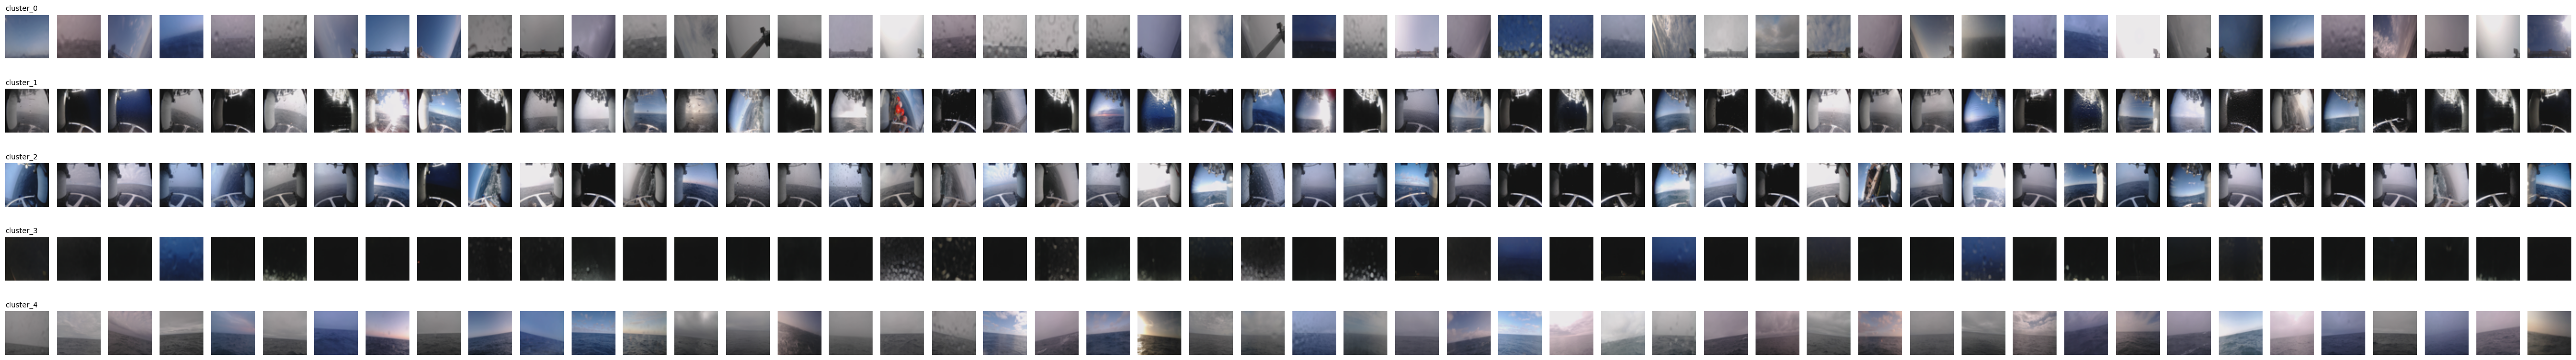

In [ ]:
# Visualize clusters with thumbnails

import os
from PIL import Image
import matplotlib.pyplot as plt

# settings
cluster_root = "dino_clusters"
clusters = [f"cluster_{i}" for i in range(5)]
images_per_cluster = 50
img_size = (48, 48)  # size for thumbnails

# create large figure: 5 rows (clusters) x 50 columns
fig, axes = plt.subplots(nrows=5, ncols=50, figsize=(50, 5 * 1.5))

for row_idx, cluster in enumerate(clusters):
    cluster_dir = os.path.join(cluster_root, cluster)
    image_files = [f for f in os.listdir(cluster_dir) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:images_per_cluster]

    for col_idx, fname in enumerate(image_files):
        img_path = os.path.join(cluster_dir, fname)
        ax = axes[row_idx, col_idx]
        try:
            img = Image.open(img_path).convert("RGB").resize(img_size)
            ax.imshow(img)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            ax.axis("off")
            continue
        ax.axis("off")
    
    # Label the first image in the row with the cluster name
    axes[row_idx, 0].set_title(cluster, fontsize=10, loc='left')

plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.tight_layout()
plt.show()


# Just so we can see the other photos, let's run the unsupervised model on the non-cruise timeframe photos

#### NOTE: this was useful -- ended up not using the cruise time-frame and swapped to a "summer" schedule in notebook 4. 

Using cache found in /home/jovyan/.cache/torch/hub/facebookresearch_dino_main
100%|██████████| 93486/93486 [2:02:32<00:00, 12.71it/s]  


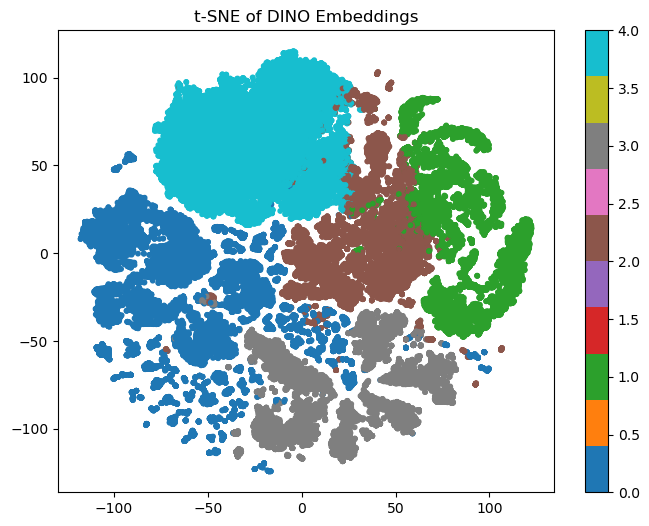

In [ ]:
# images path & general settings
image_dir = Path("./image_data/halo_filtered")
image_size = 224 # 224 for ViT's input requirements
num_clusters = 5 

# load pretrained model to start with
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
model.eval()

# transform images
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

# feature extraction
features = []
image_paths = []

for fname in tqdm(os.listdir(image_dir)):
    if fname.lower().endswith((".jpg")):
        path = os.path.join(image_dir, fname)
        try:
            img = Image.open(path).convert("RGB")
            tensor = transform(img).unsqueeze(0)
            with torch.no_grad():
                feat = model(tensor).squeeze().numpy()
            features.append(feat)
            image_paths.append(path)
        except Exception as e:
            print(f"Skipping {fname}: {e}")

# kmeans clustering
X = np.array(features)

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# group images by cluster
output_dir = "dino_clusters_noncruise"
os.makedirs(output_dir, exist_ok=True)

for cluster_id in range(num_clusters):
    cluster_dir = os.path.join(output_dir, f"cluster_{cluster_id}")
    os.makedirs(cluster_dir, exist_ok=True)

for path, label in zip(image_paths, labels):
    fname = os.path.basename(path)
    dst = os.path.join(output_dir, f"cluster_{label}", fname)
    os.system(f'cp "{path}" "{dst}"')

# PCA to see how they cluster


pca = PCA(n_components=50).fit_transform(X)
tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(pca)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne[:,0], tsne[:, 1], c=labels, cmap="tab10", s=10)
plt.title("t-SNE of DINO Embeddings")
plt.colorbar(scatter)
plt.show()

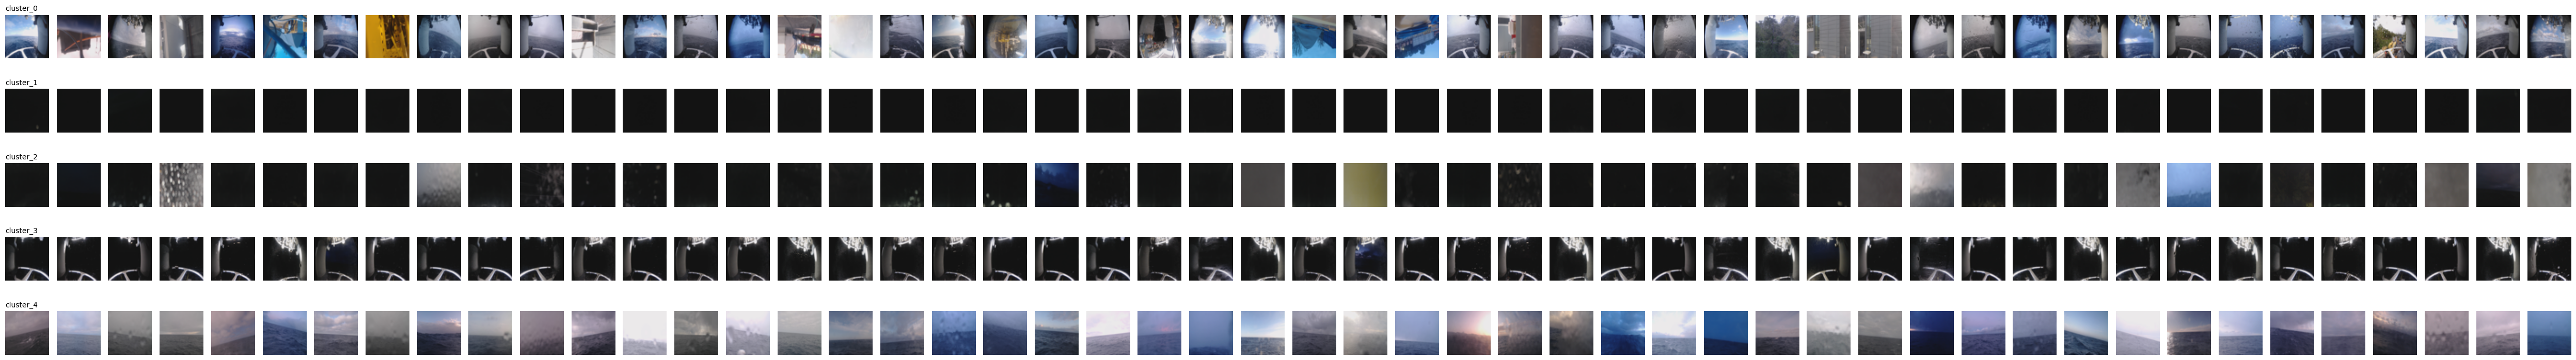

In [14]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# settings
cluster_root = "dino_clusters_noncruise"
clusters = [f"cluster_{i}" for i in range(5)]
images_per_cluster = 50
img_size = (48, 48)  # size for thumbnails

# create large figure: 5 rows (clusters) x 50 columns
fig, axes = plt.subplots(nrows=5, ncols=50, figsize=(50, 5 * 1.5))

for row_idx, cluster in enumerate(clusters):
    cluster_dir = os.path.join(cluster_root, cluster)
    image_files = [f for f in os.listdir(cluster_dir) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:images_per_cluster]

    for col_idx, fname in enumerate(image_files):
        img_path = os.path.join(cluster_dir, fname)
        ax = axes[row_idx, col_idx]
        try:
            img = Image.open(img_path).convert("RGB").resize(img_size)
            ax.imshow(img)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            ax.axis("off")
            continue
        ax.axis("off")
    
    # Label the first image in the row with the cluster name
    axes[row_idx, 0].set_title(cluster, fontsize=10, loc='left')

plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.tight_layout()
plt.show()
